# Функции ошибок. Метрики качества. Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') 

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Эпизод 3. Feature Engineering

Мы изучили данные, сделали **разведочный анализ** и узнали вот что:
- в данных нет дублей
- в данных есть пропуски - их чем-то надо закрыть
- в целевой переменной есть отрицательные значения, надо решить, оставить или удалить
- у целевой переменной длинный хвост -- надо его поправить
- в переменных об уценках нужно принять схожее решение
- колонка Data выглядит не очень трактуемой, надо с ней сотворить что-то прикладное
- в данных есть категориальные колонки, их нужно трансформировать в удобовариемый вид
- в одной из категориальных колонок - очень-очень много мелких категорий


In [3]:
data = pd.read_csv('walmart.csv', sep='\t')

# категориальные переменные 
var_cat = ['Type', 'Store', 'Dept', 'IsHoliday']

# непрерывные переменные
var_real = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5', 'CPI', 'Unemployment', 
            'Temperature', 'Fuel_Price','Size']

data.head()

,Store,Date,Dept,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,2010-02-05,1,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2010-02-05,2,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,2010-02-05,3,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,2010-02-05,4,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,2010-02-05,5,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


### Пропуски

In [4]:
# заполните пропуски

In [5]:
data.fillna(0, inplace=True)

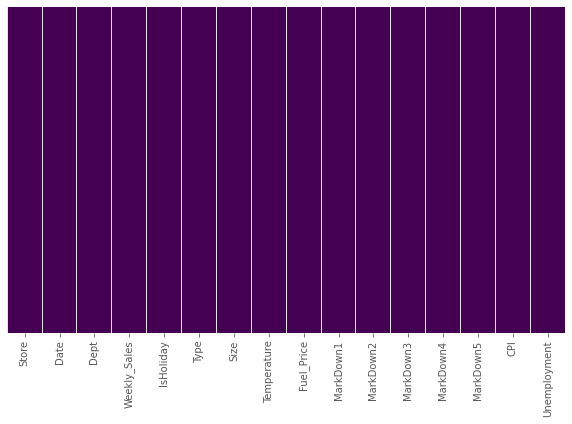

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')

### Целевая переменная

In [7]:
# удалите все строки, где целевая переменная отрицательная

In [8]:
data = data[data.Weekly_Sales > 0]

In [9]:
# c длинными хвостами борются логарифмирование
# прологарифмируйту колонку Weekly Sales и сохраните в новую ln_weekly_sales

In [10]:
data['ln_weekly_sales'] = data['Weekly_Sales'].apply(lambda w: np.log(w))

In [11]:
# визуализируйте с помощь гистограмм исходное распределение и прологарифмированное

array([[<AxesSubplot:title={'center':'Weekly_Sales'}>,
        <AxesSubplot:title={'center':'ln_weekly_sales'}>]], dtype=object)

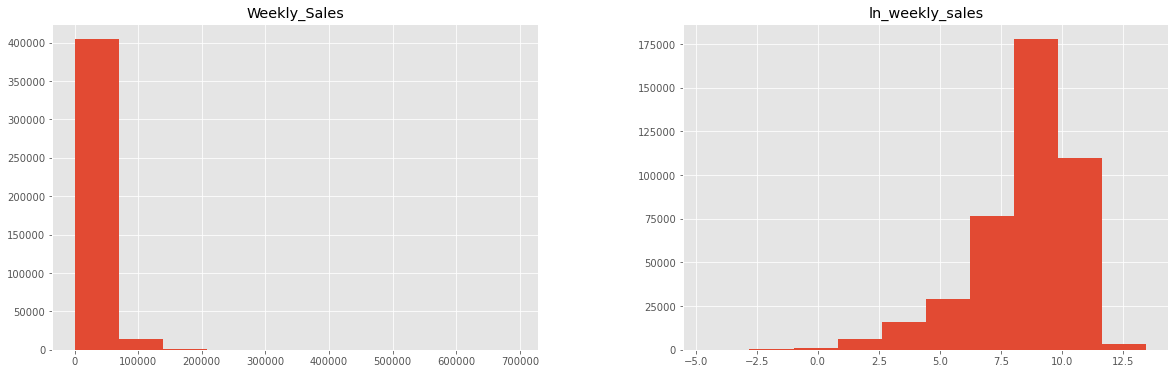

In [12]:
data[['Weekly_Sales', 'ln_weekly_sales']].hist(figsize=(20, 6))

### Дата

In [13]:
# функцией pd.to_datetime преобразуйте колонку из текста в дату

In [14]:
data.Date = pd.to_datetime(data.Date)
data.Date

0        2010-02-05
1        2010-02-05
2        2010-02-05
3        2010-02-05
4        2010-02-05
            ...    
421565   2012-10-26
421566   2012-10-26
421567   2012-10-26
421568   2012-10-26
421569   2012-10-26
Name: Date, Length: 420212, dtype: datetime64[ns]

In [15]:
# выделите в качестве признака месяц

In [16]:
data['Month'] = data['Date'].dt.month


In [17]:
data['Black_Friday'] = (np.where((data['Date']=='2010-11-26') |
                              (data['Date']=='2011-11-25') | 
                              (data['Date']=='2012-11-23'), 1, 0))

# Предрождественские деньки: 
data['Pre_christmas'] = (np.where((data['Date']=='2010-12-23') | 
                               (data['Date']=='2010-12-24') | 
                               (data['Date']=='2011-12-23') | 
                               (data['Date']=='2011-12-24') |
                               (data['Date']=='2012-12-23') | 
                               (data['Date']=='2012-12-24'), 1, 0))

### Категориальные переменные

In [18]:
# сделаем все колонки категориальных переменных типа object

In [19]:
data[var_cat] = data[var_cat].astype('object')

In [20]:
# найдем маленькие категории в колонке Dept
# 1. создадим список всех категорий
# 2. найдем большие - такие, что в них более 4000 записей
# 3. найдем разницу в этих двух списках
# 4. выведем малые категории на печатть

In [21]:
uniq_category = data['Dept'].unique()  
counts = data['Dept'].value_counts()
big_category = counts[counts > 4000].index
small_category = list(set(uniq_category) - set(big_category))
print(small_category)

[65, 99, 37, 39, 43, 45, 77, 47, 48, 78, 50, 51]


In [22]:
# заменим в колонке маленькие категории на -1, а остальные номера оставим. 
# преобразуем в строковый тип данных 

In [23]:
data['Dept'] = data['Dept'].apply(lambda w: -1 if w in small_category else w).astype('object')

In [24]:
# финальный шаг, сделаем OHE-кодирование
# удалим из датасета колонку даты, и отдадим ее функции pd.get_dummies() на растерзание

In [25]:
data_transf = pd.get_dummies(data.drop('Date', axis=1), drop_first=True, dummy_na=False)


## Эпилог

In [26]:
data['future_sales'] = data.Weekly_Sales.shift(-1)
data = data[~data['future_sales'].isna()]

## Функции  потерь регрессии

Не важно, какой задачей мы занимаемся, в основе лежит математическая функция, которую мы оптимизируем.

Например, для задачи о такси остановились на следующем:

$$ \sum{(a(x_i) - y_i)^2}$$

Допустим, мы верим, что такая модель объяснит взаимосвязь

$$ a(x_i) = w_0 + w_1*x_i,$$

где $х_i$ - это количество пассажиров в i-ой поездке, <br>
$w_0, w_1$ - не известные параметры

Оптимизации подвергнется конструкция:

$$ \min_{w_0, w_1}\sum{(w_0 + w_1*x_i - y_i)^2}$$

После применения какого-то метода оптимизации (аналитический аппарат в лице производных или численные методы в лице градиентного спуска), будут конкретные значения $w_0, w_1$

### Функция потерь
Конструкция вида 

$$ \min_{w_0, w_1}\sum{(w_0 + w_1*x_i - y_i)^2}$$

Называется **функцией потерь (loss function)**


Она помогает обучить модель = найти коэффициенты

Требований к ней не много, одно пожелание:
- дифференцируемость

### Функции потерь регрессии

$$ MSE = \frac {1}{n} \sum{(a(x_i)- y_i)^2}$$

**Плюсы**:
- дифференцируемая

**Недостатки**:
- нездоровая тяга к выбросам

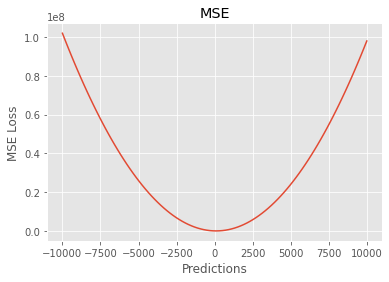

In [27]:
y = [100]*100
a = np.linspace(-10000, 10000, 100)
mse = ()
plt.title('MSE')
plt.plot(a, (a - y) **2)
plt.xlabel('Predictions')
plt.ylabel('MSE Loss')
plt.show()

$$ RMSE = \frac {1}{n} \sqrt{\sum{(a(x_i)- y_i)^2}}$$

**Плюсы**:
- дифференцируемая

**Недостатки**:
- нездоровая тяга к выбросам

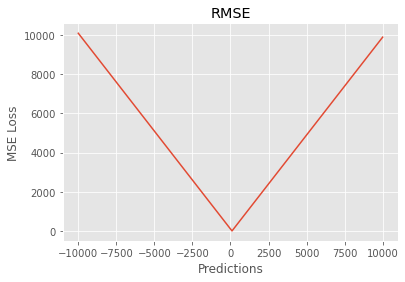

In [28]:
y = [100]*100
a = np.linspace(-10000, 10000, 100)
mse = ()
plt.title('RMSE')
plt.plot(a, ((a - y) **2)**(1/2))
plt.xlabel('Predictions')
plt.ylabel('MSE Loss')
plt.show()

$$ MAE = \frac {1}{n} \sum{|a(x_i)- y_i|}$$

**Плюсы**:
- простейший способ расчета
- вычислительно недорогой способ

**Недостатки**
- алгоритм "слеп" к ошибке в 100 и 1000 на разных объектах
- алгоритм придает равное значение всем ошибкам

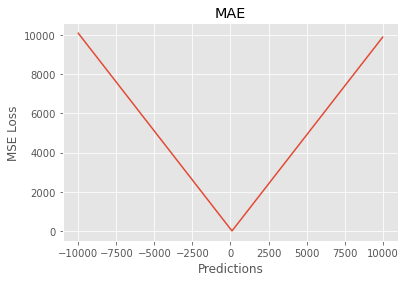

In [29]:
y = [100]*100
a = np.linspace(-10000, 10000, 100)
mse = ()
plt.title('MAE')
plt.plot(a, abs(a - y))
plt.xlabel('Predictions')
plt.ylabel('MSE Loss')
plt.show()

$$ MAPE = \frac {1}{n} \sum |{\frac{a(x_i)- y_i}{y_i}}|$$

**Плюсы**:
- ошибки выдаются в процентах, нет нужды гадать, ошибка в 10 или 100 - это много или мало

**Недостатки**
- разный процентных размах для одной и той же ошибки (|70 - 100| = 30, т.е. 0.3 ошибка; или |40 - 70| = 30, т.е. 0.42
- одно нулевое наблюдение -- все рухнет

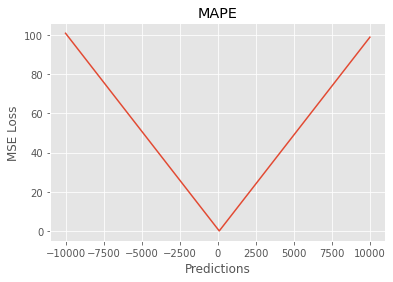

In [30]:
y = [100]*100
a = np.linspace(-10000, 10000, 100)
mse = ()
plt.title('MAPE')
plt.plot(a, abs((a - y) / y))
plt.xlabel('Predictions')
plt.ylabel('MSE Loss')
plt.show()

$$  \begin{equation*}
Huber Loss = 
 \begin{cases}
    \sum{(a(x_i)- y_i)^2} &\text{|$a(x_i) - y_i$| <= $\delta$}\\
   2*\delta|a(x_i) - y_i| - \delta^2 &\text{otherwise}
 \end{cases}
\end{equation*}$$

**Плюсы**

- гиперпараметр дельта - есть, где маневрировать
- численные методы не "перепрыгнут" оптимум

**Минусы**
- есть условия и сравнения, поэтому вычислительно мб сложно
- дельта - гиперпараметр, нуждается в оптимизации

<img src='https://miro.medium.com/max/1280/1*gTUzf_mRdIPPZ96Qi5qrgw.jpeg'>

### Резюме про функции потерь
- MSE
- RMSE
- MAE
- MAPE
- HuberLoss

Выбор функции потерь обоснован:
- задачей и ее бизнес-компонентом
- способом решения оптимизационной задачи 

## Метрики качества регрессии

Теперь есть обученный алгоритм $a(x)$, который раздал объектам прогнозы $\hat{y}$.

Нужны метрики, чтобы замерить качество (=ошибку) прогноза. 

$$ MSE = \frac {1}{n} \sum{(\hat{y_i}- y_i)^2}$$


$$ RMSE = \frac {1}{n} \sqrt{\sum{\hat{y_i}- y_i)^2}}$$

$$ MAE = \frac {1}{n} \sum{|\hat{y_i}- y_i|}$$


$$ MAPE = \frac {1}{n} \sum |{\frac{\hat{y_i}- y_i}{y_i}}|$$

$$R^2 = 1- \frac{\sum{(\hat{y_i}- y_i)^2}}{\sum{(y_i - \overline{y})^2}}$$


### Резюме про метрики
- MSE
- RMSE
- MAE
- MAPE
- $R^2$

## Расчет метрик по задачи

In [31]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [32]:
y_mean = data['future_sales'].mean()
y_pred_naive = np.ones(len(data['future_sales'])) * y_mean

In [33]:
# рассчитайте метрики 


##  Функции потерь классификации


В классификации нужно правильно раздать метки: 1 и 0.

Функция потерь записывается просто:

$$ \frac{1}{n}\sum{[a(x_i) \ne y_i]}$$

Т.е. мы стремимся уменьшить долю ошибок.

Беда такая: 

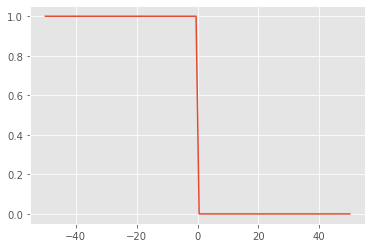

In [34]:
m = np.linspace(-50, 50, 100)
y = np.array([1]*50 + [0]*50)
plt.plot(m, y)
plt.show()

**Экспоненциальная функция потерь** 

$$ AdaBoostLoss = exp(-y*a(x))$$

**Логистическая функция потерь** 

$$ LogLoss = log(1 + exp(-2y*a(x))$$

<img src='https://habrastorage.org/r/w1560/web/bf5/9de/dcf/bf59dedcfd9d49b18e89ce342b09ce69.png'>

## Метрики классификации

**Accuracy**

Самая простая и интуитивная метрика для оценка качества классификации - это accuracy, доля правильных ответов. 
- настоящие значения (y_real)
- спрогнозированные моделью значения (y_pred)

Количество совпадений в прогнозах - это числитель в accuracy; знаменатель - это количество объектов, для которых мы сделали прогноз

$$ Accuracy = \frac{количество\:совпадений\:в\:прогнозах}{количество\:элементов} $$

Accuracy измеряется от 0 до 1. Чем ближе к 1, тем лучше: модель смогла правильно классифицировать объекты

**Матрица ошибок**

4 показателя (TP, FP, TN, FN) собираются в одну таблицу, которая называется матрицей ошибок. 

В библиотке sklearn матрица собирается следующим образом:
- по горизонтали расположены истинные метки класса от 0 до 1
- по вертикали - метки алгоритма от 0 до 1

Соответственно, 
- на диагонали стоят все правильные прогнозы
    - в левом верхнем углу TN
    - в правом нижнем углу TP
- вне диагонали - ошибочные варианты:
    - в правом верхнем углу расположились FP-ответы
    - в левом нижнем углу - TN-ответы

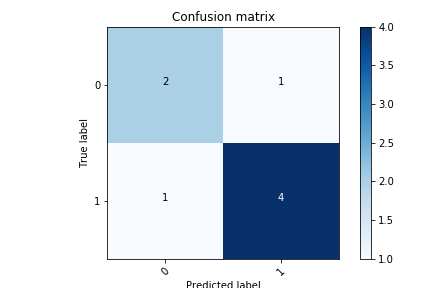

**Recall**
Для оценка качества прогноза целевого класса можно использовать метрику полноты, или Recall. 
Она показывает, какую долю положительных ответов смог выделить классификатор. 

На примере нашей задачи: 
- есть 100 человек, которые обратились за страховой компенсацией. 
- 20 из них модель распознала и посчитала обращающимися за страховкой. 
- Тогда Recall для таких цифр - 0.2

По матрице ошибок легко и быстро Recall можно рассчитывать по формуле: 
$$ Recall = \frac{TP}{TP + FN}$$

Это доля TP-ответов среди всех, у кого истинная метка - 1: сумма TP + FN

**Precision**

Качество прогноза целевого класса можно оценить метрикой точности, или Precision. 
Это доля корректных положительных меток среди всех положительных меток модели. 

На примере нашей задачи: 
- есть 100 человек, которые по мнению модели обратятся за страховкой
- 20 из них действительно обратились за компенсацией. 
- Тогда Precision  - 0.2

По матрице ошибок легко и быстро Precision можно рассчитывать по формуле: 

$$ Precision = \frac{TP}{TP + FP}$$

Корректные положительные метки - это TP, а все положительные метки, присвоенные классификатором - это TP и FP

**F1-score**

Полнота и точность оценивают качество прогноза класса 1 из-под разных углов: точность показывает адекватность модели, не переусердствует ли она, присваивая положительные метки; полнота же описывает, как глубоко модель смогла разобраться в особенностях класса 1 и распознать его.

Обе метрики - важные. Чтобы контролировать их параллельно, придуманы агрегирующие метрики. Одна из них - F1-мера или F1-score. Это среднегармонические полноты и точности. 

$$ F1 = \frac{2PR}{R + P}$$

Среднегармоническое обладает важным свойством: когда один из составляющих близок к нулю, само среднее гармоническое близится к нулю.
Т.е. если мы под любым углом плохо прогнозируем класс 1, то F1-мера близостью к нулю сразу покажет. 

**ROC-AUC**

Даны:

$y_i$ - истинные метки <br>
$p_i$ - прогнозы вероятности класса 1

$$FPR = \frac{FP}{FP + TN}$$
$$TPR = \frac{TP}{TP + FN}$$


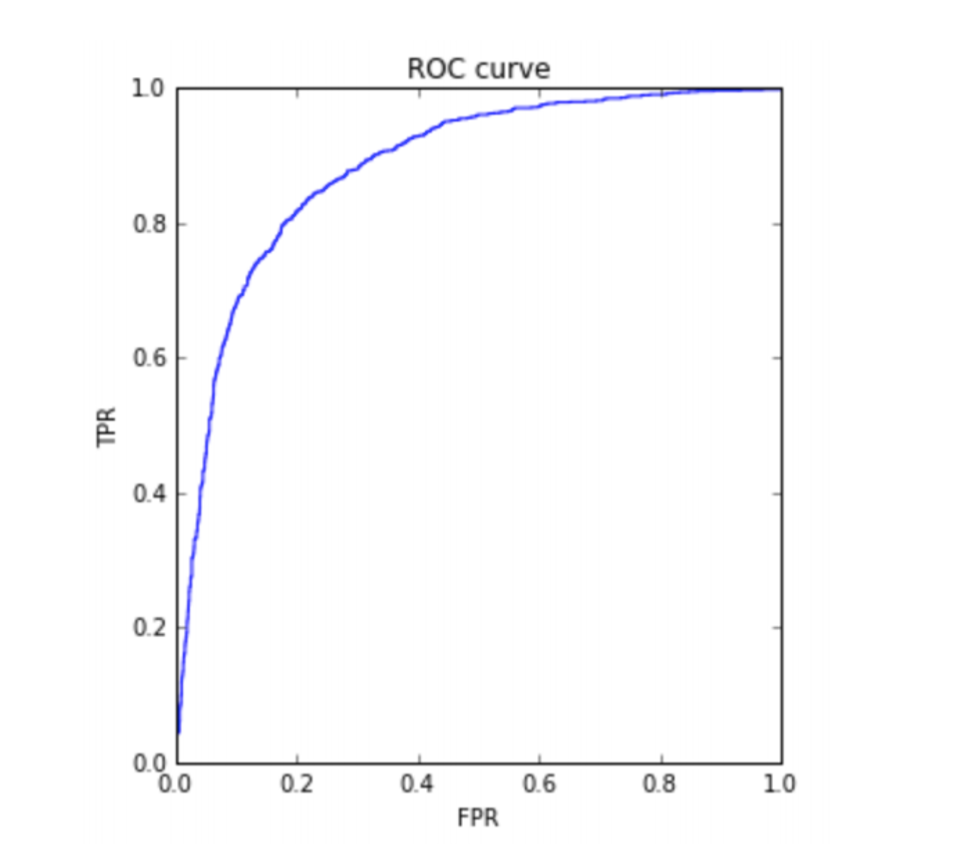

### Задачи 

**1. Метрики классификации**

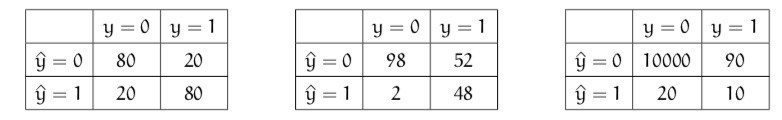

**2. AUC**

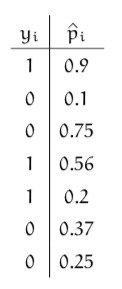

## Задачи по метрикам классификации с Python

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc

In [36]:
import pandas as pd              
import numpy as np 
import itertools
import matplotlib.pyplot as plt   
import matplotlib
import seaborn as sns             
plt.style.use('ggplot')           

%matplotlib inline

**Задача 1. Сгенерируйте две выборки:**
- y_proba - случайный вектор длины 100, от 0 до 1
- y_true - случайный вектор длины 100, состоящий из 0 и 1


In [37]:
y_proba = np.random.random(size=100)
y_true = np.random.randint(low=0, high=2, size=100)
y_pred = y_proba > 0.6
y_pred = np.array(pd.Series(y_pred).astype(int))

**Задача 2. Считаем метрики:**
- Accuracy
- Precision
- Recall
- ROC-AUC

In [38]:
# рассчитайте метрики 


**Визуализация ROC и Recall-кривых**

In [39]:
# Функция для отрисовки confusion_matrix  
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=30)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)
    pass

# Функция для отрисовки roc-auc кривой    
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    matplotlib.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass


# Картинки для PR-кривой, а-меры
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()

- Визуализируйте ROC-кривую

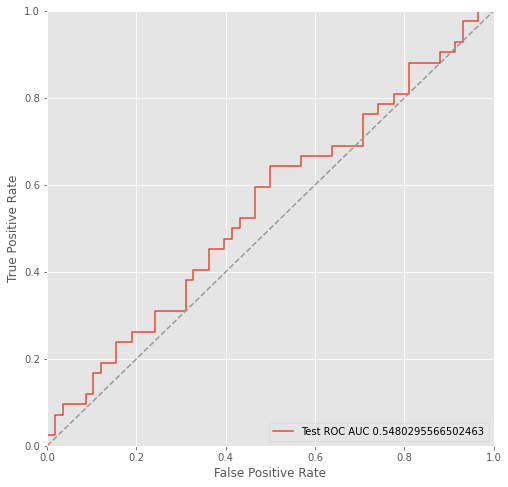

In [40]:
roc_auc_pic(y_proba, y_true)

- Визуализируйте PR-кривую

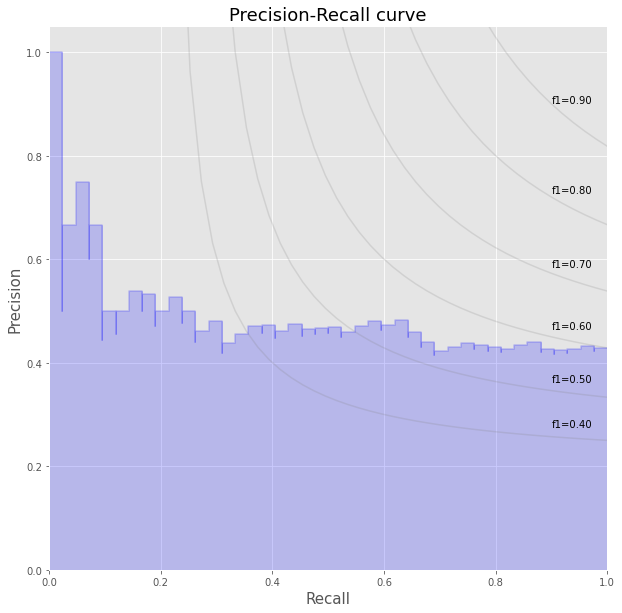

In [41]:
plot_precision_recall_curve(y_proba, y_true)

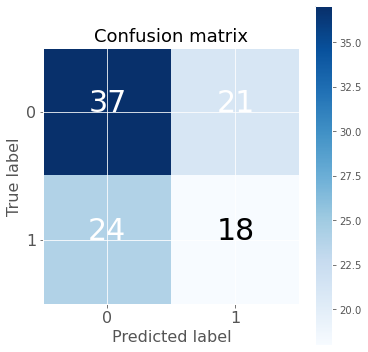

In [42]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred), classes=['0', '1'])